In [6]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np

import pymc as pm
import pytensor.tensor as pt
import pytensor
pytensor.config.cxx = '/usr/bin/clang++'

In [7]:
def exponential(n_samples, lambda_like=2.0, seed=20):
    np.random.seed(seed)
    data = np.random.exponential(1 / lambda_like, n_samples)
    return data

def load_config(config_file="config.json"):
    with open(config_file, 'r') as f:
        config = json.load(f)
    return config

def pushforward_exp_mean_std(mu, sigma):
    mu = float(np.asarray(mu).squeeze())
    sigma = float(np.asarray(sigma).squeeze())
    if sigma < 0:
        raise ValueError(f"sigma must be nonnegative, got {sigma}")

    mean = np.exp(mu + 0.5 * sigma**2)
    var  = (np.exp(sigma**2) - 1.0) * np.exp(2.0 * mu + sigma**2)
    std  = np.sqrt(var)
    return float(mean), float(std)


def traces_to_lambda_moments(mu_trace, sigma_trace):
    mu_trace = np.asarray(mu_trace, dtype=float).reshape(-1)
    sigma_trace = np.asarray(sigma_trace, dtype=float).reshape(-1)

    if mu_trace.shape[0] != sigma_trace.shape[0]:
        raise ValueError("mu_trace and sigma_trace must have the same length")

    mean = np.exp(mu_trace + 0.5 * sigma_trace**2)
    var  = (np.exp(sigma_trace**2) - 1.0) * np.exp(2.0 * mu_trace + sigma_trace**2)
    std  = np.sqrt(var)
    return mean, std

In [8]:
config_file = 'exp_config.json'
config = load_config(config_file)

lambda_like = config['lambda_like']
alpha_prior = config['alpha_prior']
beta_prior = config['beta_prior']
n_samples = config['n_samples']
grad_samps = config['grad_samps']
max_iters = 100_000#config['max_iters']
adam_step = 1e-3#config['adam_step']
data = exponential(n_samples)


def run_model(n_mc_samples = 1, optimizer = 'default', seed = 0):

    with pm.Model() as model:
        lambd = pm.Gamma('lambda', alpha=alpha_prior, beta=beta_prior)

        # Likelihood
        likelihood = pm.Exponential('likelihood', lam=1/lambd, observed=data)

        # Posterior sampling
        advi = pm.ADVI(random_seed=seed)

        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval,
        )
        if optimizer == 'default':
            approx = advi.fit(
                max_iters, callbacks=[tracker],
                progressbar=True,
                obj_n_mc=n_mc_samples,
            )
        elif optimizer == 'adam':
            approx = advi.fit(
                max_iters, callbacks=[tracker],
                progressbar=True,
                obj_n_mc=n_mc_samples,
                obj_optimizer=pm.adam(learning_rate=adam_step)
            )
    return tracker['mean'], tracker['std']

single_mus_unc, single_stds_unc = run_model()
multi_mus_unc, multi_stds_unc = run_model(n_mc_samples=100)
adam_single_mus_unc, adam_single_stds_unc = run_model(optimizer='adam')
adam_multi_mus_unc, adam_multi_stds_unc = run_model(n_mc_samples=100, optimizer='adam')


Output()

Finished [100%]: Average Loss = 0.11851


Output()

Finished [100%]: Average Loss = 0.052544


Output()

Finished [100%]: Average Loss = 0.065017


Output()

Finished [100%]: Average Loss = 0.05258


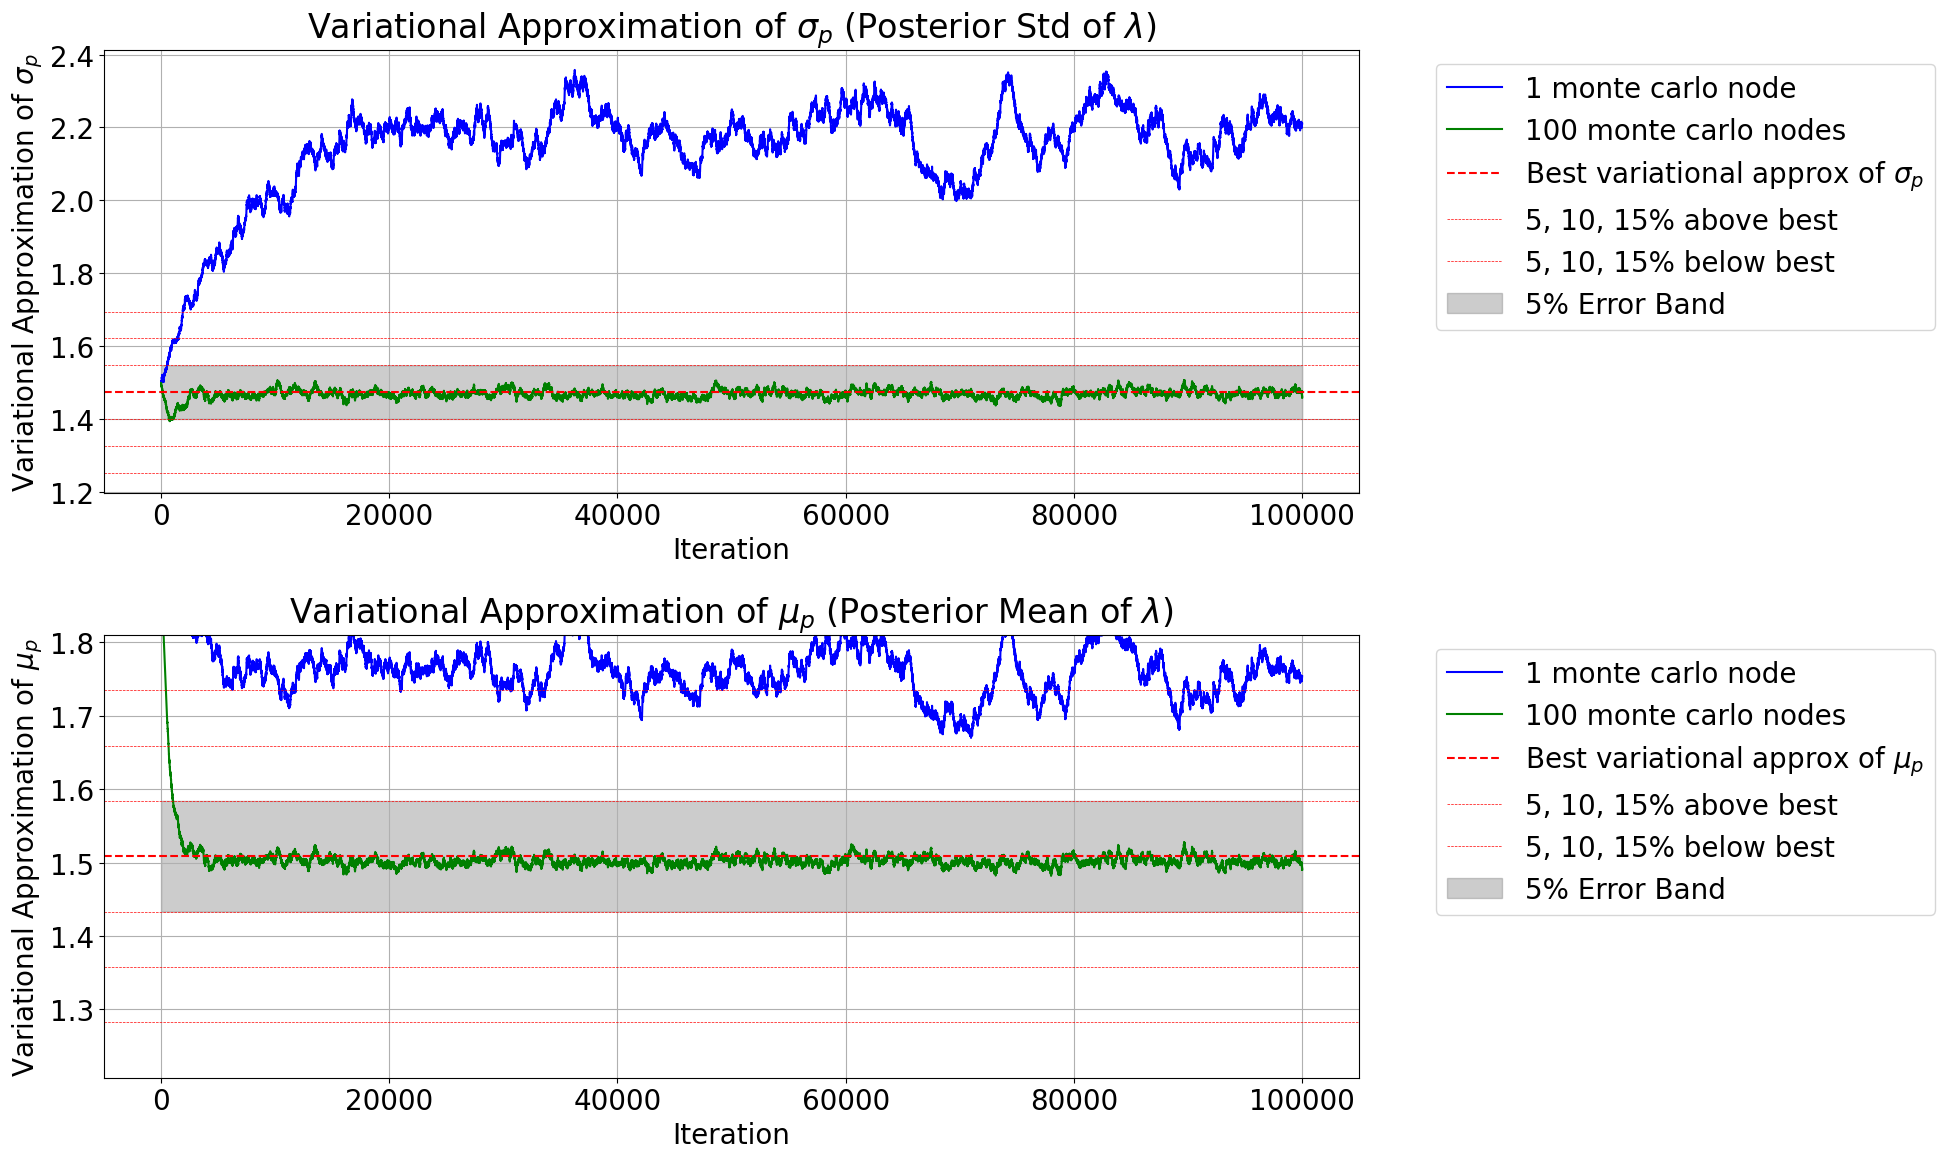

In [9]:

# ---- Convert PyMC unconstrained traces -> constrained lambda mean/std traces
single_mus, single_stds = traces_to_lambda_moments(
    single_mus_unc, single_stds_unc)
multi_mus, multi_stds = traces_to_lambda_moments(
    multi_mus_unc, multi_stds_unc)
adam_single_mus, adam_single_stds = traces_to_lambda_moments(
    adam_single_mus_unc, adam_single_stds_unc)
adam_multi_mus, adam_multi_stds = traces_to_lambda_moments(
    adam_multi_mus_unc, adam_multi_stds_unc)

best_mu_unc = config['best_mean']
best_sigma_unc = config['best_std']
best_mu, best_sigma = pushforward_exp_mean_std(best_mu_unc, best_sigma_unc)

fig, axs = plt.subplots(2, 1, figsize=(20, 12))
plt.rcParams.update({'font.size': 20})

axs[1].plot(single_mus, label='1 monte carlo node', color='blue')
axs[1].plot(multi_mus, label='100 monte carlo nodes', color='green')

axs[1].axhline(best_mu, color='red', linestyle='--', label=r'Best variational approx of $\mu_p$')
axs[1].set_title(r'Variational Approximation of $\mu_p$ (Posterior Mean of $\lambda$)')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel(r'Variational Approximation of $\mu_p$')
axs[1].grid()

axs[0].plot(single_stds, label='1 monte carlo node', color='blue')
axs[0].plot(multi_stds, label='100 monte carlo nodes', color='green')

axs[0].axhline(best_sigma, color='red', linestyle='--', label=r'Best variational approx of $\sigma_p$')
axs[0].set_title(r'Variational Approximation of $\sigma_p$ (Posterior Std of $\lambda$)')
axs[0].set_xlabel('Iteration', fontsize=20)
axs[0].set_ylabel(r'Variational Approximation of $\sigma_p$')

axs[0].grid()

for i in [5, 10, 15]:
    axs[1].axhline(best_mu * (1 + i/100), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% above best' if i == 5 else None)
    axs[1].axhline(best_mu * (1 - i/100), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% below best' if i == 5 else None)

    axs[0].axhline(best_sigma * (1 + i/100), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% above best' if i == 5 else None)
    axs[0].axhline(best_sigma * (1 - i/100), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% below best' if i == 5 else None)
axs[1].fill_between(range(max_iters), best_mu*0.95, best_mu*1.05, color='gray', alpha=0.4, label='5% Error Band')
axs[0].fill_between(range(max_iters), best_sigma*0.95, best_sigma*1.05, color='gray', alpha=0.4, label='5% Error Band')

axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# axs[0].set_ylim((best_sigma * 0.8, best_sigma * 1.2))
axs[1].set_ylim((best_mu * 0.8, best_mu * 1.2))
plt.tight_layout()
plt.show()

Let's use Adam instead.

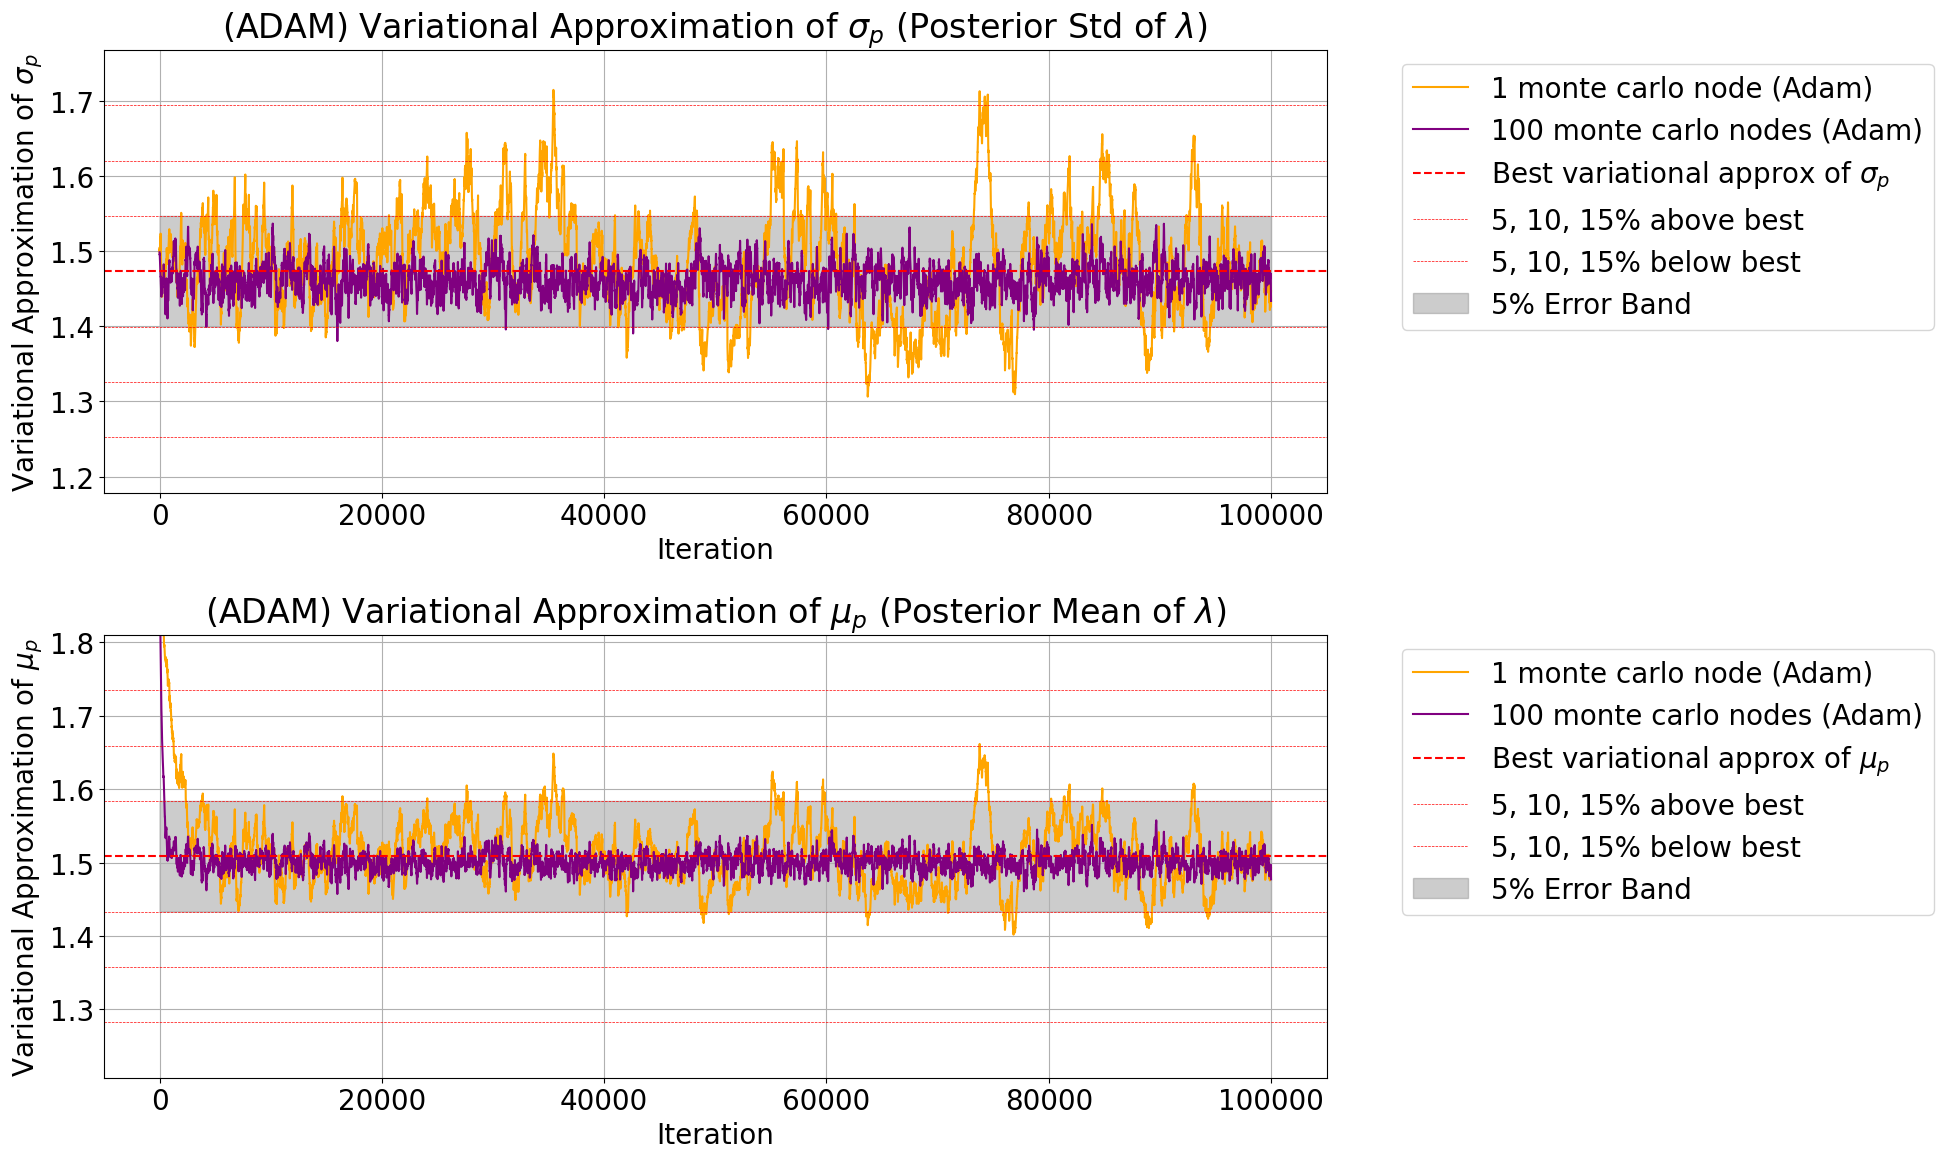

In [10]:

fig, axs = plt.subplots(2, 1, figsize=(20, 12))
plt.rcParams.update({'font.size': 20})

axs[1].plot(adam_single_mus, label='1 monte carlo node (Adam)', color='orange')
axs[1].plot(adam_multi_mus, label='100 monte carlo nodes (Adam)', color='purple')

axs[1].axhline(best_mu, color='red', linestyle='--', label=r'Best variational approx of $\mu_p$')
axs[1].set_title(r'(ADAM) Variational Approximation of $\mu_p$ (Posterior Mean of $\lambda$)')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel(r'Variational Approximation of $\mu_p$')
axs[1].grid()

axs[0].plot(adam_single_stds, label='1 monte carlo node (Adam)', color='orange')
axs[0].plot(adam_multi_stds, label='100 monte carlo nodes (Adam)', color='purple')

axs[0].axhline(best_sigma, color='red', linestyle='--', label=r'Best variational approx of $\sigma_p$')
axs[0].set_title(r'(ADAM) Variational Approximation of $\sigma_p$ (Posterior Std of $\lambda$)')
axs[0].set_xlabel('Iteration', fontsize=20)
axs[0].set_ylabel(r'Variational Approximation of $\sigma_p$')
axs[0].grid()

for i in [5, 10, 15]:
    axs[1].axhline(best_mu * (1 + i/100), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% above best' if i == 5 else None)
    axs[1].axhline(best_mu * (1 - i/100), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% below best' if i == 5 else None)

    axs[0].axhline(best_sigma * (1 + i/100), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% above best' if i == 5 else None)
    axs[0].axhline(best_sigma * (1 - i/100), color='red', linestyle='--', linewidth=0.5,
                    label='5, 10, 15% below best' if i == 5 else None)
axs[1].fill_between(range(max_iters), best_mu*0.95, best_mu*1.05, color='gray', alpha=0.4, label='5% Error Band')
axs[0].fill_between(range(max_iters), best_sigma*0.95, best_sigma*1.05, color='gray', alpha=0.4, label='5% Error Band')

axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axs[0].set_ylim((best_sigma * 0.8, best_sigma * 1.2))
axs[1].set_ylim((best_mu * 0.8, best_mu * 1.2))
plt.tight_layout()
plt.show()